# 1. import modules

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch

#from exercise_code.tests import test_seg_nn
#set up default cuda device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 2. Import dataloader

In [5]:
#device
from datasets.base_dataset import ShapeNet

In [6]:
from utils.config import options
a = ShapeNet("/mnt/raid/jliu/ShapeNet", "02691156_train_demo.lst",
                            "depth", "SDF_v1",
                            True,options.dataset.shapenet,phase='train')

[('02691156', 'a98038807a61926abce962d6c4b37336'), ('02691156', '25ae9c70ded5640ac2a9d7232db0ed61')]


In [33]:
train_loader = torch.utils.data.DataLoader(a,batch_size=1, shuffle=True,num_workers=0)
#a = next(iter(train_loader))
#a["images"].size()

In [34]:
a = next(iter(train_loader))
pc = a["sdf_points"]
print(pc.size())
img = a["images"][:,1,:,:].view(224,224).cpu().detach().numpy()
#imgs.size()
#a["filename"]
plt.imshow(img)

OSError: Unable to open file (unable to open file: name = '/mnt/raid/jliu/ShapeNet/SDF_v1/02691156/ori_sample.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [130]:
ori_sdf = np.load('tmp/ort_sdf.npy')
sam_sdf = np.load('tmp/sample_sdf.npy')
sam_sdf = sam_sdf[:, :3]
np.shape(sam_sdf)

(32768, 3)

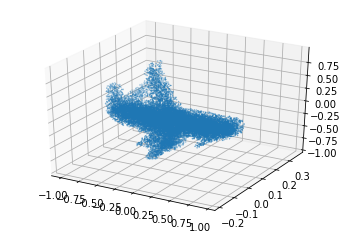

In [113]:
ori_sdf = np.load('tmp/ort_sdf.npy')
sam_sdf = np.load('tmp/sample_sdf.npy')
sam_sdf = sam_sdf[:, :3]

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
xdata = sam_sdf[:,0]
ydata = sam_sdf[:,1]
zdata = sam_sdf[:,2]
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(xdata, ydata, zdata,s=0.1, cmap='Greens');

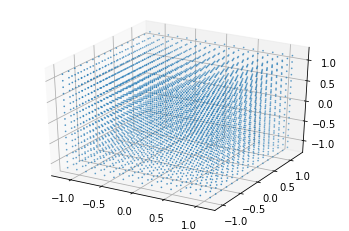

In [141]:
a = next(iter(train_loader))
sdf_params = a['sdf_params'][0].cpu()
x = np.linspace(sdf_params[0], sdf_params[3], num=16)
y = np.linspace(sdf_params[1], sdf_params[4], num=16)
z = np.linspace(sdf_params[2], sdf_params[5], num=16)
z, y, x = np.meshgrid(z, y, x, indexing='ij')
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(x, y, z,s=0.5, cmap='Greens')

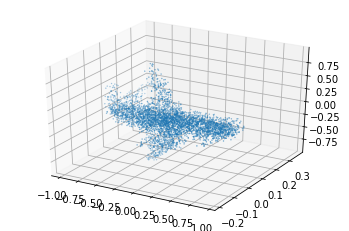

In [90]:
###"sampled sdf points"
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
xdata = pc[:,:,0].cpu().detach().numpy()
ydata = pc[:,:,1].cpu().detach().numpy()
zdata = pc[:,:,2].cpu().detach().numpy()
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(xdata, ydata, zdata,s=0.1, cmap='Greens')

In [131]:
a = next(iter(train_loader))
pc = a["sdf_points"]
trans_mat = a["trans_mat"][:,0,:,:]

homo_const = torch.ones((pc.shape[0], pc.shape[1], 1), device=pc.device, dtype=pc.dtype)
homo_pc = torch.cat((pc, homo_const), dim=-1)
pc_xyz = torch.matmul(homo_pc, trans_mat)  # pc_xyz B*N*3
pc_xy = torch.div(pc_xyz[:, :, :2], (pc_xyz[:, :, 2:]+1e-8))  # avoid divide zero
pc_xy = torch.clamp(pc_xy, 0.0, 136.0)  # pc_xy B*N*2

half_resolution = (137 - 1) / 2.
nomalized_pc_xy = ((pc_xy - half_resolution)/half_resolution).unsqueeze(1)
# print(pc.size())
# print(homo_const.size())
# print(homo_pc.size())
# print(trans_mat.size())
# print(pc_xyz.size())
# print(pc_xy.size())
# pc_xy[0,0,:]
print(nomalized_pc_xy.size())
#trans_mat
#nomalized_pc_xy[0,0,0,:]

import torch.nn.functional as F
out = []
x1 = torch.ones([4,1,56, 56], dtype=torch.float32)
f1 = F.interpolate(x1, size=137, mode='bilinear', align_corners=True)
outf1 = F.grid_sample(f1, nomalized_pc_xy, align_corners=True)
outf2 = F.grid_sample(f1, nomalized_pc_xy, align_corners=True)
out.append(outf1)
out.append(outf2)
out_all = torch.cat((out),dim=1)
out_all.size()

finish load: 00
finish load: 16
finish load: 31
finish load: 00
finish load: 16
finish load: 31
finish load: 00
finish load: 16
finish load: 31
finish load: 00
finish load: 16
finish load: 31
torch.Size([4, 1, 4096, 2])


torch.Size([4, 2, 1, 4096])

In [132]:
out.append(outf1)
out_all = torch.cat((out),dim=1)
out_all.size()

torch.Size([4, 3, 1, 4096])

In [114]:
f1.size()

torch.Size([1, 1, 137, 137])

## Visuliaze the back proj

In [70]:
nomalized_pc_xy[0,0,0,:]
grid_img = torchvision.utils.make_grid(batch_tensor, nrow=224,ncol=224)
plt.imshow(grid_img.permute(1, 2, 0))
print(pc[0,0,:])

NameError: name 'torchvision' is not defined

In [101]:
(pc[0,0,0]-pc[0,:,0].min())/0.1199
#pc[0,:,1].max()-pc[0,:,1].min()
#pc[0,:,2].max()-pc[0,:,2].min()

tensor(15.1908)

In [2]:
import numpy as np
img_dir = "/mnt/raid/jliu/ShapeNet/depth/02691156/a98038807a61926abce962d6c4b37336/easy/rendering_metadata.txt"
#params = np.loadtxt(img_dir + "/rendering_metadata.txt")
with open(img_dir) as f_input:
    text = [l.replace(",", " ") for l in f_input]
    text = [l.replace("]", " ") for l in text]
    text = [l.replace("[", " ") for l in text]
para = np.loadtxt(text)
para[0,:]

array([11.67271516, 25.41292181,  0.        ,  0.66737145, 35.        ,
       32.        ,  1.75      ,  0.        ,  0.        ,  0.        ])

In [154]:
from skimage import transform,io
img_file = "/mnt/raid/jliu/ShapeNet/depth/02691156/a98038807a61926abce962d6c4b37336/easy/00.png"
img = io.imread(img_file)
#plt.imshow(img)
img = img[:,:,0]
img.shape

from skimage import transform,io
img_file = "/mnt/raid/jliu/ShapeNet/depth/02691156/a98038807a61926abce962d6c4b37336/easy/16.png"
img_1 = io.imread(img_file)
img_1 = img_1[:,:,0]
img_1.shape

a = np.array()
a = a.append(img)
a = a.append(img_1)
print(a.shape)

img = img[:,:,np.newaxis]
img_1 = img_1[:,:,np.newaxis]
ls = [img, img_1]
img_out = np.concatenate(ls,axis = 2)
img_out.shape

#plt.imshow(img_out)

TypeError: array() missing required argument 'object' (pos 1)

## Dataloader

In [141]:
f
train_loader = torch.utils.data.DataLoader(a,batch_size=4, shuffle=True,num_workers=0)
#val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=0)

(224, 224)

In [69]:
a=[1,2]
a[1:2]

[2]

In [13]:
cat_id = '02691156'
obj = 'a98038807a61926abce962d6c4b37336'
sdf_file = os.path.join("/mnt/raid/jliu/ShapeNet/SDF_v1/02691156/a98038807a61926abce962d6c4b37336/ori_sample.h5")
b = a.get_sdf_h5(sdf_file, cat_id, obj)

In [24]:
tensor_one = torch.tensor([[1,2,3],[4,5,6]])
tensor_two = torch.tensor([[10,20,30],[40,50,60]])
tensor_list = [tensor_one, tensor_two]
stacked_tensor = torch.stack(tensor_list)
print(stacked_tensor.shape)
print(tensor_one.shape)

torch.Size([2, 2, 3])
torch.Size([2, 3])


In [ ]:
np.array([])

## Model

In [2]:
from models.model import Model

a = Model()

In [13]:
##Loss
import torch
a = torch.gt(torch.tensor([[1, 2], [3, 4]]),0.5)
a = torch.tensor([[1, 2], [3, 4]])
#print(a)
b = torch.gt(torch.tensor([[1, 1], [4, 4]]),0.5)
#print(b)
c = torch.mean(torch.eq(a,b).float())
#c
from models.loss import loss
a = 

tensor([[1., 0.],
        [0., 0.]])

## Scheduler

In [1]:
from tensorboardX import SummaryWriter

## RUN

In [38]:
%%bash
CUDA_VISIBLE_DEVICES=2 python train.py

=> creating /home/jliu/jliu/experiments/logs/default
=> creating /home/jliu/jliu/experiments/checkpoints/default/0601130550
=> creating /home/jliu/jliu/experiments/summary/default/0601130550
=> creating summary writer
/mnt/raid/jliu/ShapeNet/SDF_v1
/mnt/raid/jliu/ShapeNet/depth
('02691156', 'a98038807a61926abce962d6c4b37336')
finish load: 00
finish load: 16
finish load: 31
finish load: 00
finish load: 16
finish load: 31
finish load: 00
finish load: 16
finish load: 31
finish load: 00
finish load: 16
finish load: 31
finish load: 00
finish load: 16
finish load: 31
finish load: 00
finish load: 16
finish load: 31
finish load: 00
finish load: 16
finish load: 31
finish load: 00
finish load: 16
finish load: 31
finish load: 00
finish load: 16
finish load: 31
finish load: 00
finish load: 16
finish load: 31
finish load: 00
finish load: 16
finish load: 31
finish load: 00
finish load: 16
finish load: 31
finish load: 00
finish load: 16
finish load: 31
finish load: 00
finish load: 16
finish load: 31


Running without options file...
{'checkpoint': None,
 'checkpoint_dir': '/home/jliu/jliu/experiments/checkpoints/default/0601130550',
 'dataset': {'camera_c': [111.5, 111.5],
             'camera_f': [248.0, 248.0],
             'filelist_test': '02691156_test.lst',
             'filelist_train': '02691156_train_demo.lst',
             'img_dir': 'depth',
             'mesh_pos': [0.0, 0.0, -0.8],
             'name': 'shapenet',
             'normalization': True,
             'num_classes': 13,
             'predict': {'folder': 'predict'},
             'sdf_dir': 'SDF_v1',
             'shapenet': {'augcolorback': False,
                          'augcolorfore': False,
                          'img_alpha': False,
                          'num_points': 4096,
                          'resize_with_constant_border': False,
                          'rot': False},
             'voxel_dir': 'ShapeNetVox32'},
 'experiments_dir': 'experiments',
 'log_dir': '/home/jliu/jliu/experiments/lo

In [40]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline  
train = torch.load('tmp/out_train.pt')
train_sdf = train['pred_sdf'].view(1,-1).cpu().detach().numpy()
val = torch.load('tmp/out_val.pt')
val_sdf = val['pred_sdf'].view(1,-1).cpu().detach().numpy()

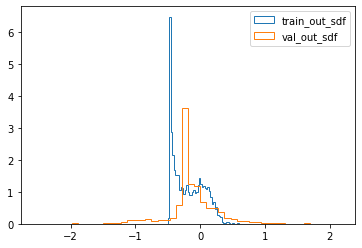

In [45]:
plt.hist(train_sdf.flatten(),50,facecolor='g',density=True,histtype='step',label='train_out_sdf')
plt.hist(val_sdf.flatten(),50,facecolor='r',density=True,histtype='step',label='val_out_sdf')
plt.legend(loc='upper right')
plt.show()

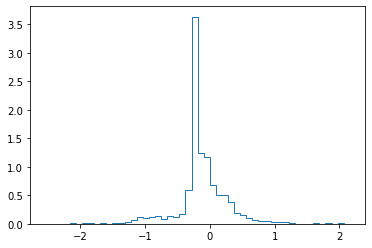

In [42]:
plt.hist(val_sdf.flatten(),50,facecolor='r',density=True,histtype='step')
plt.show()

In [ ]:
commute_times = [23, 25, 40, 35, 36, 47, 33, 28, 48, 34,
                 20, 37, 36, 23, 33, 36, 20, 27, 50, 34,
                 47, 18, 28, 52, 21, 44, 34, 13, 40, 49]
plt.hist(train_sdf[0:100])
plt.show()

In [67]:
for i in range(3):
    print(i)
for i in range(4):
    print(i)

0
1
2
0
1
2
3


In [ ]:
print("Train size: %i" % len(train_data))
print("Validation size: %i" % len(val_data))
print("Img size: ", train_data[0][0].size())
print("Segmentation size: ", train_data[0][1].size())

num_example_imgs = 4
plt.figure(figsize=(10, 5 * num_example_imgs))
for i, (img, target) in enumerate(train_data[:num_example_imgs]):
    # img
    plt.subplot(num_example_imgs, 2, i * 2 + 1)
    plt.imshow(img.numpy().transpose(1,2,0))
    plt.axis('off')
    if i == 0:
        plt.title("Input image")
    
    # target
    plt.subplot(num_example_imgs, 2, i * 2 + 2)
    plt.imshow(label_img_to_rgb(target.numpy()))
    plt.axis('off')
    if i == 0:
        plt.title("Target image")
plt.show()

## Test

In [5]:
%%bash
CUDA_VISIBLE_DEVICES=2 python predict.py

Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.


CalledProcessError: Command 'b'CUDA_VISIBLE_DEVICES=2 python predict.py\n'' returned non-zero exit status 1.

We can already see that the dataset is quite small in comparison to our previous datasets, e.g., for CIFAR10 we had ten thousands of images while we only have 276 training images in this case. In addition, the task is much more difficult than a "simple 10 class classification", as we have to assign a label to each pixel! What's more, the images are much bigger as we are now considering images of size 240x240 instead of 32x32. 

That means that you shouldn't expect our networks to perform very well, so don't be too disappointed.

# 2. Semantic Segmentation 

## Dummy Model

In `exercise_code/networks/segmentation_nn.py` we define a naive `DummySegmentationModel`, which always predicts the scores of segmentations labels of the first image. Let's try it on a few images and visualize the output using the `visualizer` we provide. The `visualizer` takes in the model and dataset, and visualizes the first four (Input, Target, Prediction) pairs. 

In [ ]:
dummy_model = DummySegmentationModel(target_image=train_data[0][1])

# Visualization function
visualizer(dummy_model, train_data)

If you want, you can use the visualizer function in your training scenario to print out your model predictions on a regular basis.

## Loss and Metrics
The loss function for the task of image segmentation is a pixel-wise cross entropy loss. This loss examines each pixel individually, comparing the class predictions (depth-wise pixel vector) to our one-hot encoded target vector. 
<img src='images/loss_img.png' width=80% height=80%/>
source: https://www.jeremyjordan.me/semantic-segmentation/

Up until now we only used the default loss function (`nn.CrossEntropyLoss`) in our solvers. However, In order to ignore the `unlabeled` pixels for the computation of our loss, we have to use a customized version of the loss for the initialization of our segmentation solver. The `ignore_index` argument of the loss can be used to filter the `unlabeled` pixels and computes the loss only over remaining pixels.


In [ ]:
loss_func = torch.nn.CrossEntropyLoss(ignore_index=-1, reduction='mean')

for (inputs, targets) in train_data[0:4]:
    inputs, targets = inputs, targets
    outputs = dummy_model(inputs.unsqueeze(0))
    losses = loss_func(outputs, targets.unsqueeze(0))
    print(losses)

<div class="alert alert-warning">
    <h3>Note: Non-zero loss for the first sample</h3> 
    <p>The output of our dummy model is one-hot-coded tensor. Since there is <b>softmax</b> function in the <b>nn.CrossEntropyLoss</b> function, the loss is:  
    $$loss(x, class) = - \log \left( \frac{\exp(x[class])}{\Sigma_j \exp (x[j])} \right) = −x[class]+\log \left( \Sigma_j \exp(x[j]) \right)$$
     and the loss will not be zero.    </p>
<p>i.e. for $x=[0, 0, 0, 1],class=3$,$\quad$ the loss: 
$loss(x,class) = -1 +\log(\exp(0)+\exp(0)+\exp(0)+\exp(1)) = 0.7437$ </p>
</div>

To obtain an evaluation accuracy, we can simply compute the average per pixel accuracy of our network for a given image. We will use the following function:

In [ ]:
def evaluate_model(model, dataloader):
    test_scores = []
    model.eval()
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model.forward(inputs)
        _, preds = torch.max(outputs, 1)
        targets_mask = targets >= 0
        test_scores.append(np.mean((preds.cpu() == targets.cpu())[targets_mask].numpy()))

    return np.mean(test_scores)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=1,shuffle=False,num_workers=0)
print(evaluate_model(dummy_model, test_loader))

You will see reasonably high numbers as your accuracy when you do the training later. The reason behind that is the fact that most output pixels are of a single class and the network can just overfit to common classes such as "grass".

## Step 1: Design your own model

<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p>Implement your network architecture in <code>exercise_code/networks/segmentation_nn.py</code>. In this task, you will use pytorch to setup your model.
    </p>
</div>

To compensate for the dimension reduction of a typical convolution layer, you should probably include either a single `nn.Upsample` layer, using a combination of upsampling layers as well as convolutions or even transposed convolutions near the end of your network to get back to the target image shape.

This file is mostly empty but contains the expected class name, and the methods that your model needs to implement (only `forward()` basically). 
The only rules your model design has to follow are:
* Inherit from `torch.nn.Module` or `pytorch_lightning.LightningModule`
* Perform the forward pass in `forward()`. Input dimension is (N, C, H, W) and output dimension is (N, num_classes, H, W)
* Have less than 5 million parameters
* Have a model size of less than 50MB after saving

Furthermore, you need to pass all your hyperparameters to the model in a single dict `hparams`.

<div class="alert alert-warning">
    <h3>Note: Transfer learning</h3>
    <p>In this exercise, we encourage you to do transfer learning as we learned in exercise 8, since this will boost your model performance and save training time. You can import pretrained models from torchvision in your model and use its feature extractor (e.g. <code>alexnet.features</code>) to get the image features. Feel free to choose more advanced pretrained model like ResNet, MobileNet for your architecture design.</p>       
</div>

See [here](https://pytorch.org/vision/stable/models.html) for more info of the torchvison pretrained models.


In [ ]:
hparams = {
    # TODO: if you have any model arguments/hparams, define them here and read them from this dict inside SegmentationNN class
}

In [ ]:
model = SegmentationNN(hparams = hparams)
test_seg_nn(model)

## Step 2: Train your own model

<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p> In addition to the network itself, you will also need to write the codes for the model training. You can use PyTorch Lightning for that, or you can also write it yourself in standard PyTorch.
    </p>
</div>

In [ ]:
model = SegmentationNN(hparams=hparams)
########################################################################
# TODO - Train Your Model                                              #
########################################################################
import torch.optim as optim

num_epochs = 3
log_nth = 5  # log_nth: log training accuracy and loss every nth iteration
batch_size = 8


train_loss_history = []
train_acc_history = []
val_acc_history = []
val_loss_history = []
val_data
train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size, shuffle=True,num_workers=0)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=0)

optimizer = optim.Adam(
    model.parameters(),
    lr=1e-4,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0.0
    )

iter_per_epoch = len(train_loader)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

print('START TRAIN.')

for epoch in range(num_epochs):
    # TRAINING
    train_acc_epoch = []
    for i, (inputs, targets) in enumerate(train_loader, 1):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_func(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss_history.append(loss.cpu().detach().numpy())
        if log_nth and i % log_nth == 0:
            last_log_nth_losses = train_loss_history[-log_nth:]
            train_loss = np.mean(last_log_nth_losses)
            print('[Iteration %d/%d] TRAIN loss: %.3f' %
                  (i + epoch * iter_per_epoch,
                   iter_per_epoch * num_epochs,
                   train_loss))

        _, preds = torch.max(outputs, 1)

        # Only allow images/pixels with label >= 0 e.g. for segmentation
        targets_mask = targets >= 0
        train_acc = np.mean((preds == targets)[
                            targets_mask].cpu().detach().numpy())
        train_acc_history.append(train_acc)
        train_acc_epoch.append(train_acc)


    if log_nth:
        train_acc =  np.mean(train_acc_epoch)
        print('[Epoch %d/%d] TRAIN acc/loss: %.3f/%.3f' % (epoch + 1,
                                                           num_epochs,
                                                           train_acc,
                                                           train_loss))
    # VALIDATION
    val_losses = []
    val_scores = []
    model.eval()
    for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model.forward(inputs)
        loss = loss_func(outputs, targets)
        val_losses.append(loss.detach().cpu().numpy())

        _, preds = torch.max(outputs, 1)

        # Only allow images/pixels with target >= 0 e.g. for
        # segmentation
        targets_mask = targets >= 0
        scores = np.mean((preds == targets)[
                         targets_mask].cpu().detach().numpy())
        val_scores.append(scores)

    model.train()
    val_acc, val_loss = np.mean(val_scores), np.mean(val_losses)
    val_acc_history.append(val_acc)
    val_loss_history.append(val_loss)
    if log_nth:
        print('[Epoch %d/%d] VAL   acc/loss: %.3f/%.3f' % (epoch + 1,
                                                           num_epochs,
                                                           val_acc,
                                                           val_loss))
#######################################################################
#                           END OF YOUR CODE                          #
#######################################################################

# 3. Test your Model

In [ ]:
test(evaluate_model(model, test_loader))

# 4. Visualization

In [ ]:
visualizer(model, test_data)

## Save the Model for Submission

When you are satisfied with your training, save the model for [submission](https://i2dl.vc.in.tum.de/submission/). In order to be eligible for the bonus points you have to achieve an accuracy above __60%__.

In [ ]:
os.makedirs('models', exist_ok=True)
save_model(model, "segmentation_nn.model")
checkSize(path = "./models/segmentation_nn.model")

In [ ]:
from exercise_code.util.submit import submit_exercise

submit_exercise('exercise10')


# Submission Goals

- Goal: Implement and train a convolutional neural network for Semantic Segmentation.
- Passing Criteria: Reach **Accuracy >= 60%** on __our__ test dataset. The submission system will show you your score after you submit.

- Submission start: __Thursday, June 10, 2021 - 13:00__
- Submission deadline: __Wednesday, June 16, 2021 - 15:59__
- You can make **$\infty$** submissions until the deadline. Your __best submission__ will be considered for bonus